Adapted from https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb

## Import TensorFlow and enable eager execution

In [5]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

## Load the dataset

In [87]:
from PIL import Image

def build_images_data(cyrillic_path):
    image_classes = []
    image_data = []
    characters = []
    for dirName, subdirList, fileNames in os.walk(cyrillic_path):
        for i, fileName in enumerate(fileNames):
            if fileName.endswith(".png"):
    #             print "{n}. {dirName}/{fileName}".format(n=i, dirName=dirName, fileName=fileName)
                img_bitmap = get_image_data(os.path.join(dirName, fileName))
                image_data.append(img_bitmap)
                character = dirName.split("/")[-1]
                if character not in characters:
                    characters.append(character)
                image_classes.append(characters.index(character))
    return image_data, image_classes

binarizer = np.vectorize(lambda i: 1 if i > 0 else 0)

def get_image_data(filepath):
        img = Image.open(filepath)
        img = img.resize((28, 28), Image.ANTIALIAS)
        bitmap = np.array(img.getdata())
        bitmap = bitmap[:,3] # only need the fourth item in the RGB (transparency)
        bitmap = binarizer(bitmap) # change bitmap to 1 or 0
        img.close()
        return list(bitmap)

In [88]:
cyrillic_path = "../Cyrillic"
        
x_data, y_data = build_images_data(cyrillic_path)

In [91]:
y_data = np.array(y_data)
y_data.reshape(y_data.shape[0])

In [93]:
x_data = np.array(x_data)
x_data = x_data.reshape(x_data.shape[0], 28, 28, 1).astype('float32')

In [94]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

## Use tf.data to create batches and shuffle the dataset

In [108]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator and Discriminator

In [96]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    
    self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    
    self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)

  def call(self, x, training=True):
    x = self.fc1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)

    x = tf.reshape(x, shape=(-1, 7, 7, 64))

    x = self.conv1(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = tf.nn.relu(x)

    x = tf.nn.tanh(self.conv3(x))  
    return x

In [97]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.conv1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv2(x))
    x = self.dropout(x, training=training)
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [98]:
generator = Generator()
discriminator = Discriminator()

In [99]:
# Defun gives 10 secs/epoch performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

## Define the loss functions and the optimizer

In [100]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [101]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [102]:
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints (Object-based saving)

In [103]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training & Generate Images

In [104]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [105]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [106]:
def train(dataset, epochs, noise_dim):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      # generating noise from a uniform distribution
      noise = tf.random_normal([BATCH_SIZE, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

      
    if epoch % 1 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [109]:
train(train_dataset, EPOCHS, noise_dim)

Time taken for epoch 150 is 109.738123894 sec


## Restore the latest checkpoint

In [110]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [113]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

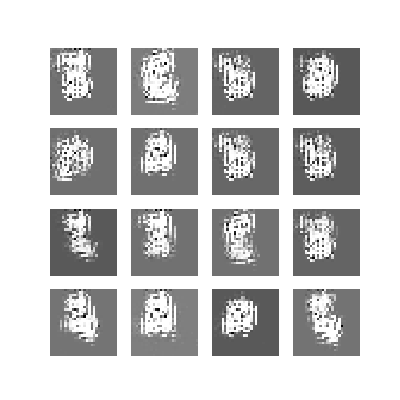

In [114]:
display_image(EPOCHS)

## Generate a GIF of all the saved images.

<!-- TODO(markdaoust): Remove the hack when Ipython version is updated -->


In [115]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

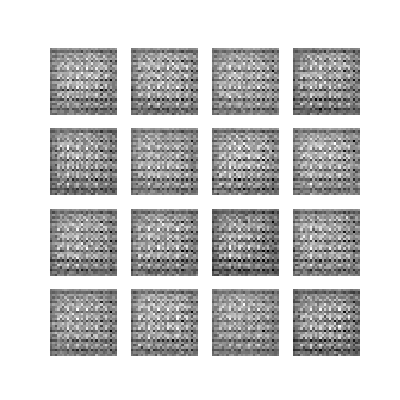

In [116]:
display.Image(filename="dcgan.gif.png")

To downlod the animation from Colab uncomment the code below:

In [0]:
#from google.colab import files
#files.download('dcgan.gif')